In [2]:
# Tạo đường dẫn chung để đọc utils
import sys
import os

# Từ data/TrietHoc/ cần đi lên 2 cấp để về root directory
current_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))  # Lên 2 cấp
sys.path.append(root_dir)

print(f"Current directory: {current_dir}")
print(f"Root directory: {root_dir}")
print(f"Python path: {sys.path[-1]}")

Current directory: d:\Documents\TDTU\Kiến tập\RAG_GeneralSubject\data\TrietHoc
Root directory: d:\Documents\TDTU\Kiến tập\RAG_GeneralSubject
Python path: d:\Documents\TDTU\Kiến tập\RAG_GeneralSubject


In [3]:
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer, LTTextLine, LTChar
from pypdf import PdfReader

from langchain.text_splitter import RecursiveCharacterTextSplitter
from utils.load_chunks_json import load_chunks_from_json
from utils.save_chunks_json import save_chunks_to_json
from utils.bm25 import bm25_tokenize, text_to_sparse_vector_bm25

from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi

import unicodedata
import torch
import numpy as np
import re

# ***Chunk văn bản***

In [4]:
def get_text_size_TrietHoc(pdf_path, total_pages):
    '''
        Hàm được sử dụng để kiểm tra xem toàn bộ các size text có trong tài liệu, chuẩn bị cho việc chunking
        Các tham số:
            - pdf_path: đường dẫn đến file pdf của môn Lịch sử đảng
        
        Hàm sẽ trả về 1 set chứa toàn bộ các text_size của tài liệu
    '''
    #Duyệt qua từng trang trong file pdf, bắt đầu từ trang 2 (bỏ qua trang bìa)
    size_set = set()
    for page_layout in extract_pages(pdf_path, page_numbers=range(2, total_pages)):
        
        #Duyệt qua từng phần tử trong trang
        for element in page_layout:
            if isinstance(element, LTTextContainer):

                # Duyet qua từng dòng chữ trong phần tử
                for text_line in element:
                    if isinstance(text_line, LTTextLine):
                        
                        #Lấy ra từng kí tự bên trong dòng chữ
                        for obj in text_line:
                            if isinstance(obj, LTChar):

                                #Lấy ra thông tin của kí tự
                                font = obj.fontname
                                text = obj.get_text()
                                text_size = obj.size

                                size_set.add(text_size)
    
    return size_set

# Xây dựng các hàm cần thiết cho quá trình xử lý văn bản

In [5]:
def parse_line(line):
    """
    Tách định danh và tiêu đề từ các dòng đề mục.

    Ví dụ:
    - 'Phần II  Những nguyên lý...' → ('Phần II', 'Những nguyên lý...')
    - 'Chương V  Vật chất...'       → ('Chương V', 'Vật chất...')
    - 'II- Nguồn gốc...'            → ('II-', 'Nguồn gốc...')
    - '3. Kết cấu...'               → ('3.', 'Kết cấu...')
    - 'b) Theo chiều sâu...'        → ('b)', 'Theo chiều sâu...')

    Nếu không khớp, trả về ('None', original_line)
    """

    line = line.strip()

    pattern = re.compile(
        r"""^
        (
            (Phần|Chương)\s+[IVXLCDM\d]+            # Phần II, Chương V
            |
            [IVXLCDM]+[-\.]                         # II- hoặc II.
            |
            \d+[\.\)]                               # 3. hoặc 3)
            |
            [a-zA-Z][\.\)]                          # a) hoặc A.
        )
        \s+(.+)                                     # phần còn lại là tiêu đề
        """, re.VERBOSE | re.IGNORECASE
    )

    match = pattern.match(line)
    if match:
        number = match.group(1).strip().rstrip(".-)")  # loại . - )
        title = match.group(3).strip()
        return number, title
    else:
        return "", line

In [6]:
def normalize_text(text):
    """
    Chuyển chuỗi thành lowercase, xóa dấu, và xóa toàn bộ khoảng trắng.
    """
    # Lowercase
    text = text.lower()

    # Bỏ dấu
    text = unicodedata.normalize('NFD', text)
    text = ''.join(c for c in text if unicodedata.category(c) != 'Mn')

    # Xóa toàn bộ khoảng trắng (space, tab, newline)
    text = re.sub(r'\s+', '', text)

    return text

In [7]:
#Hàm dùng để nhận thông tin từ raw chunks, chuyển đổi sang DENSE vector để chuẩn bị nạp vào Database
def TrietHoc_raw_to_dense(part, chapter, section, subsection, sub_subsection, content, model, max_chars = 2048, global_chunk_counter=None):

    #Tách các đề mục sang số mục và tiêu đề
    part_number, part_title = parse_line(part)
    chapter_number, chapter_title = parse_line(chapter)
    section_number, section_title = parse_line(section)
    subsection_number, subsection_title = parse_line(subsection)
    sub_subsection_number, sub_subsection_title = parse_line(sub_subsection)

    chunk_type = 'EXERCISES' if ("Câu hỏi ôn tập" in section or "câu hỏi ôn tập" in section) else 'THEORY'

    from langchain.text_splitter import RecursiveCharacterTextSplitter

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_chars,
        chunk_overlap=300,
        separators=["\n\n", "\n", ".", " ", ""]
    )
    content_chunks = splitter.split_text(content)

    result = []
    for i, content_piece in enumerate(content_chunks):
        if global_chunk_counter is not None:
            # Sử dụng global counter để đảm bảo hoàn toàn unique
            unique_id = f"TrietHoc_chunk_{global_chunk_counter['count']:05d}"
            global_chunk_counter['count'] += 1
        else:
            # Fallback về cách cũ nếu không có global counter
            unique_id = f"TrietHoc_{normalize_text(part_number) if part_number else 0}_{normalize_text(chapter_number) if chapter_number else 0}_{section_number if section_number else 0}_{subsection_number if section_number else 0}_{sub_subsection_number if sub_subsection_number else 0}_{i}"  
        chunk = {
            "id": f"{unique_id}",
            "values": model.encode(content).tolist(),
            "metadata": {
                "subject": "Triết học Mác_Lênin",
                "part": part_number,
                "part_title": part_title,
                "chapter": chapter_number,
                "chapter_title": chapter_title,
                "section": section_number,
                "section_title": section_title,
                "subsection": subsection_number,
                "subsection_title": subsection_title,
                "sub_subsection": sub_subsection_number,
                "sub_subsection_title": sub_subsection_title,
                "content": content_piece,
                "tokens": len(content_piece),
                "type": chunk_type
            }
        }
        result.append(chunk)

    return result

In [24]:
#Hàm dùng để nhận thông tin từ raw chunks, chuyển đổi sang SPARSE vector để chuẩn bị nạp vào Database
def TrietHoc_raw_to_sparse(part, chapter, section, subsection, sub_subsection, content, bm25 = None, vocabluary = None, max_chars = 2048, global_chunk_counter=None):

    #Tách các đề mục sang số mục và tiêu đề
    part_number, part_title = parse_line(part)
    chapter_number, chapter_title = parse_line(chapter)
    section_number, section_title = parse_line(section)
    subsection_number, subsection_title = parse_line(subsection)
    sub_subsection_number, sub_subsection_title = parse_line(sub_subsection)

    chunk_type = 'EXERCISES' if ("Câu hỏi ôn tập" in section or "câu hỏi ôn tập" in section) else 'THEORY'

    from langchain.text_splitter import RecursiveCharacterTextSplitter

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_chars,
        chunk_overlap=300,
        separators=["\n\n", "\n", ".", " ", ""]
    )
    content_chunks = splitter.split_text(content)

    result = []
    for i, content_piece in enumerate(content_chunks):
        if global_chunk_counter is not None:
            # Sử dụng global counter để đảm bảo hoàn toàn unique
            unique_id = f"TrietHoc_chunk_{global_chunk_counter['count']:05d}"
            global_chunk_counter['count'] += 1
        else:
            # Fallback về cách cũ nếu không có global counter
            unique_id = f"TrietHoc_{normalize_text(part_number) if part_number else 0}_{normalize_text(chapter_number) if chapter_number else 0}_{section_number if section_number else 0}_{subsection_number if section_number else 0}_{sub_subsection_number if sub_subsection_number else 0}_{i}"
        
        chunk = {
            "id": f"{unique_id}",
            "values":[],
            "sparse_values": text_to_sparse_vector_bm25(content_piece.strip(), bm25, vocabluary),
            "metadata": {
                "subject": "Triết học Mác_Lênin",
                "part": part_number,
                "part_title": part_title,
                "chapter": chapter_number,
                "chapter_title": chapter_title,
                "section": section_number,
                "section_title": section_title,
                "subsection": subsection_number,
                "subsection_title": subsection_title,
                "sub_subsection": sub_subsection_number,
                "sub_subsection_title": sub_subsection_title,
                "content": content_piece,
                "tokens": len(content_piece),
                "type": chunk_type
            }
        }
        result.append(chunk)

    return result

# Xử lý tách văn bản thành các chunks

In [9]:
#Phân chia các tiêu đề
SUBSECTION_PATTERN = re.compile(r"^\s*\d+[\.\)]")    # 1. hoặc 2)
SUBSECTION_PATTERN_CHAP2 = re.compile(r"^\s*[IVX]+-", re.IGNORECASE)   # 1. hoặc 2)
SUB_SUBSECTION_PATTERN = re.compile(r"^\s*[a-zA-Z][\.\)]")  # a), b.

In [10]:
#Hàm đung để kiểm tra xem tiêu đề hiện tại có phải sub section không
def is_subsection(line_chars, chapter_title):
    line = ''.join([obj.get_text() for obj in line_chars]).strip()
    if "Chương II  " in chapter_title:
        return bool(SUBSECTION_PATTERN_CHAP2.match(line))
    return bool(SUBSECTION_PATTERN.match(line))

#Hàm đung để kiểm tra xem tiêu đề hiện tại có phải subsub section không
def is_sub_subsection(line_chars, chapter_title):
    line = ''.join([obj.get_text() for obj in line_chars]).strip()
    if "Chương II " in chapter_title:
        return bool(SUBSECTION_PATTERN.match(line))
    return bool(SUB_SUBSECTION_PATTERN.match(line))

#Hàm đung để kiểm tra xem hiện tại có phải câu hỏi ôn tập hay không
def is_questions(line_chars):
    line = ''.join([obj.get_text() for obj in line_chars]).strip()
    return ("Câu hỏi ôn tập" in line or "câu hỏi ôn tập" in line)

In [11]:
#Hàm dùng để trả về diction chứa các phần raw_chunks của môn Triết Học
def get_raw_chunks(pdf_path, total_pages):
    is_content = False

    chunk_list = []

    part_title = curr_content_line =  ""
    chapter_title = curr_content_line =  ""
    section_title = curr_content_line =  ""
    subsection_title = curr_content_line =  ""
    sub_subsection_title = curr_content_line =  ""
    curr_content_line = curr_content_line =  ""

    for page_layout in extract_pages(pdf_path, page_numbers=range(3, total_pages)):
        
        #Duyệt qua từng phần tử trong trang
        for element in page_layout:
            if isinstance(element, LTTextContainer):

                # Duyet qua từng dòng chữ trong phần tử
                for text_line in element:
                    if isinstance(text_line, LTTextLine):

                        line_chars = [obj for obj in text_line if isinstance(obj, LTChar)]
                        
                        for i, obj in enumerate(line_chars):
                            font = obj.fontname
                            text = obj.get_text()
                            text_size = obj.size

                            #Xử lý các phần lớn
                            if text_size >= 22 :
                                if is_content:
                                    
                                    chunk_list.append({
                                        "part": part_title,
                                        "chapter": chapter_title,
                                        "section": section_title,
                                        "sub_section": subsection_title,
                                        "sub_subsection": sub_subsection_title,
                                        "content": curr_content_line
                                    })
                                    is_content = False
                                    part_title = chapter_title = section_title = subsection_title = sub_subsection_title = curr_content_line =  ""
                                
                                if i == len(line_chars) - 1:
                                    part_title = part_title + text + " "
                                else:   
                                    part_title += text
                            
                            #Xử lý các chương lớn
                            elif text_size == 18:
                                if is_content:
                                    
                                    chunk_list.append({
                                        "part": part_title,
                                        "chapter": chapter_title,
                                        "section": section_title,
                                        "sub_section": subsection_title,
                                        "sub_subsection": sub_subsection_title,
                                        "content": curr_content_line
                                    })
                                    is_content = False
                                    chapter_title = section_title = subsection_title = sub_subsection_title = curr_content_line =  ""
                                
                                if i == len(line_chars) - 1:
                                    chapter_title = chapter_title + text + " "
                                else:   
                                    chapter_title += text

                            #Xử lý các mục I, II, III,...
                            #Trong chương 2 thì đây sẽ là các phần A, B, C lớn (Dobe)
                            elif 13.5 < text_size < 14:
                                if is_content:
                                    
                                    chunk_list.append({
                                        "part": part_title,
                                        "chapter": chapter_title,
                                        "section": section_title,
                                        "sub_section": subsection_title,
                                        "sub_subsection": sub_subsection_title,
                                        "content": curr_content_line
                                    })
                                    is_content = False
                                    section_title = subsection_title = sub_subsection_title = curr_content_line =  ""
                                
                                if i == len(line_chars) - 1:
                                    section_title = section_title + text + " "
                                else:   
                                    section_title += text

                            #Xử lý phần câu hỏi ôn tập ở mỗi chương (Được xem là 1 mục trong chương)
                            if is_questions(line_chars):
                                if is_content:
                                    
                                    chunk_list.append({
                                        "part": part_title,
                                        "chapter": chapter_title,
                                        "section": section_title,
                                        "sub_section": subsection_title,
                                        "sub_subsection": sub_subsection_title,
                                        "content": curr_content_line
                                    })
                                    is_content = False
                                    section_title = subsection_title = sub_subsection_title = curr_content_line =  ""
                                
                                if i == len(line_chars) - 1:
                                    section_title = section_title + text + " "
                                else:   
                                    section_title += text

                            #Xử lý các mục con như 1, 2, 3
                            #Trong chương 2 thì đây sẽ là các phần I, II, III la mã
                            elif 13 <= text_size <= 13.1 and is_subsection(line_chars, chapter_title):
                                if is_content:
                                    
                                    chunk_list.append({
                                        "part": part_title,
                                        "chapter": chapter_title,
                                        "section": section_title,
                                        "sub_section": subsection_title,
                                        "sub_subsection": sub_subsection_title,
                                        "content": curr_content_line
                                    })
                                    is_content = False
                                    subsection_title = sub_subsection_title = curr_content_line =  ""

                                if i == len(line_chars) - 1:
                                    subsection_title = subsection_title + text + " "
                                else:   
                                    subsection_title += text

                            #Xử lý các mục con như a, b, c,..
                            #Trong chương 2 thì đây sẽ là các phần 1, 2, 3
                            elif 13 <= text_size <= 13.1 and is_sub_subsection(line_chars, chapter_title):
                                if is_content:
                                    
                                    chunk_list.append({
                                        "part": part_title,
                                        "chapter": chapter_title,
                                        "section": section_title,
                                        "sub_section": subsection_title,
                                        "sub_subsection": sub_subsection_title,
                                        "content": curr_content_line
                                    })
                                    is_content = False
                                    sub_subsection_title = curr_content_line =  ""

                                if i == len(line_chars) - 1:
                                    sub_subsection_title = sub_subsection_title + text + " "
                                else:   
                                    sub_subsection_title += text

                            # Xử lý các trường hợp nội dung còn lại
                            elif 11.6 <= text_size < 12.4:
                                is_content = True
                                if i == len(line_chars) - 1:
                                    curr_content_line = curr_content_line + text + " "
                                else:   
                                    curr_content_line += text
    if is_content:
        
        chunk_list.append({
            "part": part_title,
            "chapter": chapter_title,
            "section": section_title,
            "sub_section": subsection_title,
            "sub_subsection": sub_subsection_title,
            "content": curr_content_line
        })
    
    return chunk_list

# ***Tạo ra Dense Vector và Sparse Vector từ Raw***

## Tạo Dense Vector

In [12]:
def chunk_with_embedding(raw_chunks, embedding_model):
    """
    Nhận vào danh sách raw_chunks, sau đó gọi hàm split_chunk_langchain để xử lý nhỏ ra và thêm embedding nếu cần.
    """
    final_chunks = []
    global_chunk_counter = {'count': 0}  # Khởi tạo global counter
    for chunk in raw_chunks:
        split_chunks = TrietHoc_raw_to_dense(
            chunk['part'],
            chunk['chapter'],
            chunk['section'],
            chunk['sub_section'],
            chunk['sub_subsection'],
            chunk['content'],
            max_chars=2048,
            model=embedding_model,
            global_chunk_counter=global_chunk_counter
        )
        final_chunks.extend(split_chunks)

    return final_chunks

## Tạo Sparse Vector

In [13]:
def chunk_with_sparse(raw_chunks, bm25, vocabulary):
    """
    Nhận vào danh sách raw_chunks, sau đó gọi hàm split_chunk_langchain để xử lý nhỏ ra và thêm embedding nếu cần.
    """
    final_chunks = []
    global_chunk_counter = {'count': 0} 
    for chunk in raw_chunks:
        split_chunks = TrietHoc_raw_to_sparse(
            chunk['part'],
            chunk['chapter'],
            chunk['section'],
            chunk['sub_section'],
            chunk['sub_subsection'],
            chunk['content'],
            bm25=bm25,
            vocabluary=vocabulary,
            global_chunk_counter=global_chunk_counter
        )
        final_chunks.extend(split_chunks)

    return final_chunks

## ***Hàm thực hiện parent document chunks***

In [ ]:
def create_parent_document_chunks(parent_chunks, embedding_model, child_chunk_size=512, overlap=100):
    """
    Tạo child chunks từ parent chunks với embedding
    
    Args:
        parent_chunks: Danh sách parent chunks từ file Dense.json
        embedding_model: Model embedding để tạo vector cho child chunks
        child_chunk_size: Kích thước tối đa của mỗi child chunk (ký tự)
        overlap: Độ overlap giữa các child chunks
    
    Returns:
        child_chunks: Danh sách child chunks với embedding
    """
    child_chunks = []
    global_child_counter = 0  # Đảm bảo ID unique
    
    # Khởi tạo text splitter cho child chunks
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=child_chunk_size,
        chunk_overlap=overlap,
        separators=["\n\n", "\n", ".", "!", "?", " ", ""]
    )
    
    for parent_chunk in parent_chunks:
        parent_id = parent_chunk['id']
        content = parent_chunk['metadata']['content']
        
        # Chỉ chunk những parent có content dài > child_chunk_size
        if len(content) <= child_chunk_size:
            # Nếu parent đủ ngắn, giữ nguyên nhưng sử dụng global counter
            child_chunk = {
                "id": f"{parent_id}_child_{global_child_counter}",
                "values": embedding_model.encode(content).tolist(),
                "metadata": {
                    **parent_chunk['metadata'],  # Copy toàn bộ metadata từ parent
                    "parent_id": parent_id,
                    "child_index": 0
                }
            }
            child_chunks.append(child_chunk)
            global_child_counter += 1
        else:
            # Chunk content thành nhiều phần nhỏ
            sub_contents = splitter.split_text(content)
            
            for i, sub_content in enumerate(sub_contents):
                child_chunk = {
                    "id": f"{parent_id}_child_{global_child_counter}",
                    "values": embedding_model.encode(sub_content.strip()).tolist(),
                    "metadata": {
                        **parent_chunk['metadata'],  # Copy toàn bộ metadata từ parent
                        "content": sub_content.strip(),  # Override content với sub_content
                        "parent_id": parent_id,
                        "child_index": i,
                        "tokens": len(sub_content.strip())  # Update token count
                    }
                }
                child_chunks.append(child_chunk)
                global_child_counter += 1
    
    return child_chunks

# ***Tạo các file json cần thiết***

# ***Main***

In [25]:
pdf_path = "./Triet_Hoc.pdf"

# Lấy số trang trong file PDF
reader = PdfReader(pdf_path)
total_pages = len(reader.pages)
print("Số trang trong PDF:", total_pages)

# Lấy ra toàn bộ fontsize của file PDF
# size_set = get_text_size_TrietHoc(pdf_path, total_pages)
# print(size_set)

# - Phân loại các nội dung (Format của môn Triết học sẽ theo thứ tự: Phần -> Chương -> I, II, III,... -> 1, 2,... -> a, b, c,....):
#     - Kích thước chữ >= 22: Các phần và tiêu đề của các phần đó
#     - Kích thước chữ == 18: Chương và các tiêu đề của Chương
#     - Kích thước chữ == 14 (> 13.5 and < 14): Các mục I, II, III (Có thể là ABC đối với chương II và 123 đói với chương IV)
#     - Kích thước chữ == 13 (13 <= text_size < 13.1): Các mục con như 1, 2, 3,... (Đối với chương 2 sẽ là I, II, III,...) và các mục nhỏ hơn như a, b, c....
#     - Kích thước chữ == 12 (11.6 <= text_size < 12,4): Nội dung của môn

# Đọc file PDF, chuyển qua RAW chunks
TrietHoc_raw_chunks = get_raw_chunks(pdf_path, total_pages)

# Đưa RAW chunks vào chuyển đổi sang Dense Vector
embedding_model = SentenceTransformer("AITeamVN/Vietnamese_Embedding")
embedding_model.max_seq_length = 2048
# TrietHoc_dense_vector = chunk_with_embedding(TrietHoc_raw_chunks, embedding_model)

# Đưa RAW chunks vào chuyển đổi sang Sparse Vector
corpus_texts = [chunk["content"] for chunk in TrietHoc_raw_chunks]
tokenized_corpus = [bm25_tokenize(text) for text in corpus_texts]
bm25 = BM25Okapi(tokenized_corpus)
vocabulary = list(bm25.idf.keys())
TrietHoc_sparse_vector = chunk_with_sparse(TrietHoc_raw_chunks, bm25, vocabulary)


# # #Lưu các Vector vừa tạo được vào file Json

# # Lưu RAW vào JSON
# save_chunks_to_json(TrietHoc_raw_chunks, r"./TrietHoc_Raw.json")
# # Lưu Dense Vector
# save_chunks_to_json(TrietHoc_dense_vector, r"./TrietHoc_Dense_Global.json")
# # Lưu Sparse Vector
save_chunks_to_json(TrietHoc_sparse_vector, r"./TrietHoc_Sparse_Global.json")                    

# # Đọc file Json 
# TrietHoc_raw_vector = load_chunks_from_json(r"./TrietHoc_Raw.json")
# TrietHoc_dense_vector = load_chunks_from_json(r"./TrietHoc_Dense.json")
# TrietHoc_sparse_vector = load_chunks_from_json(r"./TrietHoc_Sparse.json")

parsing for Object Streams


Số trang trong PDF: 215
✅ Đã lưu 400 chunks vào: ./TrietHoc_Sparse_Global.json
✅ Đã lưu 400 chunks vào: ./TrietHoc_Sparse_Global.json


# ***Parent chunking Triết học***

## Kiểm tra duplicate id trong triết học

In [15]:
TrietHoc_raw_vector = load_chunks_from_json(r"./TrietHoc_Raw.json")
TrietHoc_dense_vector = load_chunks_from_json(r"./TrietHoc_Dense_Global.json")
TrietHoc_sparse_vector = load_chunks_from_json(r"./TrietHoc_Sparse_Global.json")

In [16]:
test_list = [chunk["id"] for chunk in TrietHoc_dense_vector]
test_set = set(test_list)

print("Tổng số chunks trong TrietHoc_dense_vector:", len(test_list))
print("Tổng số id unique trong TrietHoc_dense_vector:", len(test_set))

Tổng số chunks trong TrietHoc_dense_vector: 400
Tổng số id unique trong TrietHoc_dense_vector: 400


## Thực hiện thống kê độ dài các chunk

### Thực hiện thống kê qua distribution và boxplot để quan sát phân bố độ dài của các chunk

THỐNG KÊ ĐỘ DÀI CONTENT:
Tổng số chunks: 400
Độ dài trung bình: 1499.10 ký tự
Độ dài ngắn nhất: 81 ký tự
Độ dài dài nhất: 2048 ký tự
Độ lệch chuẩn: 604.10
Trung vị: 1850.00
Phân vị 25%: 1045.00
Phân vị 50%: 1850.00
Phân vị 75%: 1981.25
Phân vị 90%: 2024.10
Phân vị 95%: 2036.00


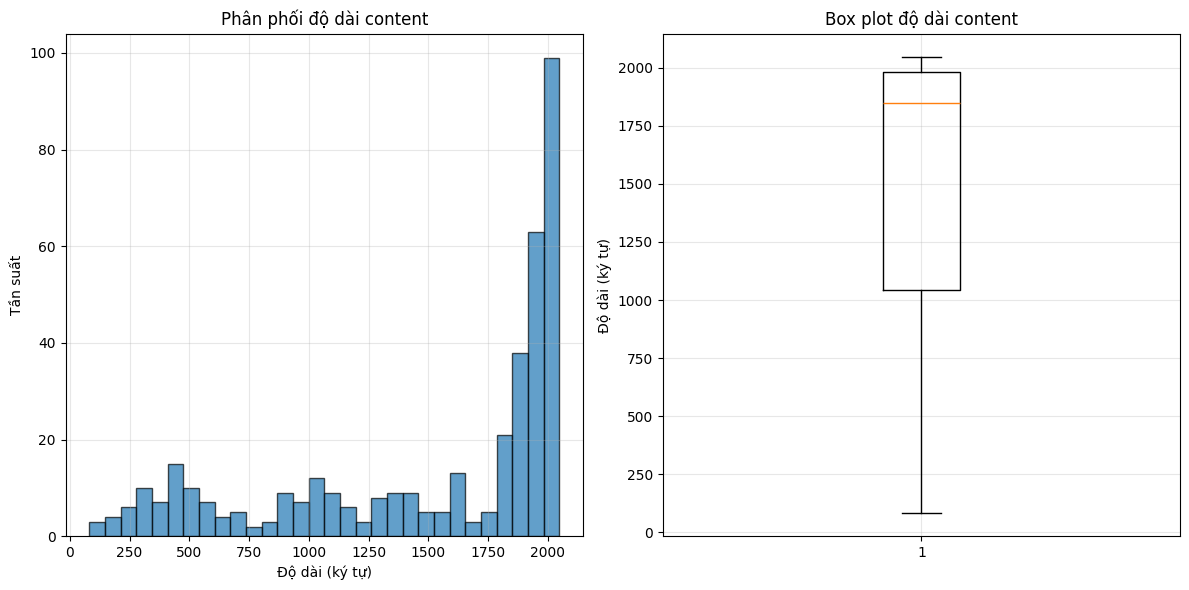


PHÂN TÍCH CHUNKING:
Số chunks có độ dài > 1000 ký tự: 308
Tỷ lệ: 77.00%


In [17]:
# Phân tích thống kê độ dài content
import matplotlib.pyplot as plt
import numpy as np

dense_chunk = TrietHoc_dense_vector  # Sử dụng biến đã đọc từ file JSON
# Lấy độ dài content của mỗi chunk
content_lengths = [len(chunk['metadata']['content']) for chunk in dense_chunk]

print("THỐNG KÊ ĐỘ DÀI CONTENT:")
print(f"Tổng số chunks: {len(dense_chunk)}")
print(f"Độ dài trung bình: {np.mean(content_lengths):.2f} ký tự")
print(f"Độ dài ngắn nhất: {np.min(content_lengths)} ký tự")
print(f"Độ dài dài nhất: {np.max(content_lengths)} ký tự")
print(f"Độ lệch chuẩn: {np.std(content_lengths):.2f}")
print(f"Trung vị: {np.median(content_lengths):.2f}")

# Phân vị
percentiles = [25, 50, 75, 90, 95]
for p in percentiles:
    print(f"Phân vị {p}%: {np.percentile(content_lengths, p):.2f}")

# Vẽ histogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(content_lengths, bins=30, alpha=0.7, edgecolor='black')
plt.title('Phân phối độ dài content')
plt.xlabel('Độ dài (ký tự)')
plt.ylabel('Tần suất')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(content_lengths)
plt.title('Box plot độ dài content')
plt.ylabel('Độ dài (ký tự)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Đếm số chunk có độ dài > 1000 ký tự (cần chunking)
long_chunks = [length for length in content_lengths if length > 1000]
print(f"\nPHÂN TÍCH CHUNKING:")
print(f"Số chunks có độ dài > 1000 ký tự: {len(long_chunks)}")
print(f"Tỷ lệ: {len(long_chunks)/len(content_lengths)*100:.2f}%")

In [18]:
# PHÂN TÍCH VÀ OPTIMIZE CHUNKING PARAMETERS

def analyze_chunk_distribution(chunks, chunk_size_threshold=1500):
    """
    Phân tích phân phối chunks và đề xuất optimize parameters
    """
    content_lengths = [len(chunk['metadata']['content']) for chunk in chunks]
    
    print("=== PHÂN TÍCH CHI TIẾT ===")
    print(f"Tổng số chunks: {len(chunks)}")
    print(f"Độ dài trung bình: {np.mean(content_lengths):.0f} ký tự")
    print(f"Độ dài median: {np.median(content_lengths):.0f} ký tự")
    print(f"Độ dài max: {np.max(content_lengths)} ký tự")
    print(f"Độ dài min: {np.min(content_lengths)} ký tự")
    
    # Phân loại chunks theo độ dài
    short_chunks = [l for l in content_lengths if l < 500]
    medium_chunks = [l for l in content_lengths if 500 <= l < 1000]
    long_chunks = [l for l in content_lengths if 1000 <= l < chunk_size_threshold]
    very_long_chunks = [l for l in content_lengths if l >= chunk_size_threshold]
    
    print(f"\n=== PHÂN LOẠI CHUNKS ===")
    print(f"Chunks ngắn (< 500 ký tự): {len(short_chunks)} ({len(short_chunks)/len(chunks)*100:.1f}%)")
    print(f"Chunks trung bình (500-999 ký tự): {len(medium_chunks)} ({len(medium_chunks)/len(chunks)*100:.1f}%)")
    print(f"Chunks dài (1000-{chunk_size_threshold-1} ký tự): {len(long_chunks)} ({len(long_chunks)/len(chunks)*100:.1f}%)")
    print(f"Chunks rất dài (>= {chunk_size_threshold} ký tự): {len(very_long_chunks)} ({len(very_long_chunks)/len(chunks)*100:.1f}%)")
    
    # Phân tích theo loại content
    theory_chunks = [chunk for chunk in chunks if chunk['metadata']['type'] == 'THEORY']
    exercise_chunks = [chunk for chunk in chunks if chunk['metadata']['type'] == 'EXERCISES']
    
    print(f"\n=== PHÂN LOẠI THEO LOẠI NỘI DUNG ===")
    print(f"Chunks lý thuyết: {len(theory_chunks)} ({len(theory_chunks)/len(chunks)*100:.1f}%)")
    print(f"Chunks bài tập: {len(exercise_chunks)} ({len(exercise_chunks)/len(chunks)*100:.1f}%)")
    
    if theory_chunks:
        theory_lengths = [len(chunk['metadata']['content']) for chunk in theory_chunks]
        print(f"Độ dài trung bình lý thuyết: {np.mean(theory_lengths):.0f} ký tự")
    
    if exercise_chunks:
        exercise_lengths = [len(chunk['metadata']['content']) for chunk in exercise_chunks]
        print(f"Độ dài trung bình bài tập: {np.mean(exercise_lengths):.0f} ký tự")
    
    return {
        'content_lengths': content_lengths,
        'short_chunks': len(short_chunks),
        'medium_chunks': len(medium_chunks),
        'long_chunks': len(long_chunks),
        'very_long_chunks': len(very_long_chunks),
        'theory_chunks': len(theory_chunks),
        'exercise_chunks': len(exercise_chunks)
    }

# Phân tích dữ liệu hiện tại
analysis_results = analyze_chunk_distribution(dense_chunk)

=== PHÂN TÍCH CHI TIẾT ===
Tổng số chunks: 400
Độ dài trung bình: 1499 ký tự
Độ dài median: 1850 ký tự
Độ dài max: 2048 ký tự
Độ dài min: 81 ký tự

=== PHÂN LOẠI CHUNKS ===
Chunks ngắn (< 500 ký tự): 49 (12.2%)
Chunks trung bình (500-999 ký tự): 43 (10.8%)
Chunks dài (1000-1499 ký tự): 59 (14.8%)
Chunks rất dài (>= 1500 ký tự): 249 (62.3%)

=== PHÂN LOẠI THEO LOẠI NỘI DUNG ===
Chunks lý thuyết: 388 (97.0%)
Chunks bài tập: 12 (3.0%)
Độ dài trung bình lý thuyết: 1531 ký tự
Độ dài trung bình bài tập: 483 ký tự


In [22]:
# Thực hiện Parent Document Chunking với chiến lược tối ưu
print("THỰC HIỆN CHUNKING VỚI CHIẾN LƯỢC TỐI ƯU")
print("="*50)

# Áp dụng Balanced Strategy: 450 ký tự, overlap 75
optimal_child_size = 450
optimal_overlap = 75

print(f"Tham số chunking:")
print(f"  - Child chunk size: {optimal_child_size} ký tự")
print(f"  - Overlap: {optimal_overlap} ký tự")
print(f"  - Separators: [\\n\\n, \\n, ., !, ?, ' ', '']")

# Tạo child chunks với tham số tối ưu
child_chunks_optimal = create_parent_document_chunks(
    parent_chunks=dense_chunk,
    embedding_model=embedding_model,
    child_chunk_size=optimal_child_size,
    overlap=optimal_overlap
)

print(f"\nKẾT QUẢ CHUNKING:")
print(f"  - Parent chunks: {len(dense_chunk)}")
print(f"  - Child chunks: {len(child_chunks_optimal)}")
print(f"  - Tỷ lệ tăng: {len(child_chunks_optimal)/len(dense_chunk):.1f}x")

# Thống kê chi tiết
child_lengths_optimal = [len(chunk['metadata']['content']) for chunk in child_chunks_optimal]
print(f"\nTHỐNG KÊ CHILD CHUNKS TỐI ƯU:")
print(f"  - Độ dài trung bình: {np.mean(child_lengths_optimal):.1f} ký tự")
print(f"  - Độ dài min: {np.min(child_lengths_optimal)} ký tự")
print(f"  - Độ dài max: {np.max(child_lengths_optimal)} ký tự")
print(f"  - Độ lệch chuẩn: {np.std(child_lengths_optimal):.1f}")

# Phân tích phân vị
percentiles = [25, 50, 75, 90, 95]
print(f"PHÂN VỊ CHILD CHUNKS:")
for p in percentiles:
    print(f"  - Phân vị {p}%: {np.percentile(child_lengths_optimal, p):.1f} ký tự")

# Kiểm tra chunks có vượt quá threshold không
over_threshold = [length for length in child_lengths_optimal if length > 500]
print(f"\nKIỂM TRA CHẤT LƯỢNG:")
print(f"  - Chunks > 500 ký tự: {len(over_threshold)} ({len(over_threshold)/len(child_chunks_optimal)*100:.1f}%)")
print(f"  - Chunks < 100 ký tự: {len([l for l in child_lengths_optimal if l < 100])} ({len([l for l in child_lengths_optimal if l < 100])/len(child_chunks_optimal)*100:.1f}%)")

# Sample một vài chunks
print(f"\n🔍 SAMPLE CHILD CHUNKS TỐI ƯU:")
for i in range(min(3, len(child_chunks_optimal))):
    chunk = child_chunks_optimal[i]
    content_preview = chunk['metadata']['content'][:80] + "..." if len(chunk['metadata']['content']) > 80 else chunk['metadata']['content']
    print(f"\nChild {i+1}:")
    print(f"  ID: {chunk['id']}")
    print(f"  Parent: {chunk['metadata']['parent_id']}")
    print(f"  Length: {len(chunk['metadata']['content'])} chars")
    print(f"  Content: {content_preview}")

print(f"\n🎯 CHUẨN BỊ LƯU FILE...")

THỰC HIỆN CHUNKING VỚI CHIẾN LƯỢC TỐI ƯU
Tham số chunking:
  - Child chunk size: 450 ký tự
  - Overlap: 75 ký tự
  - Separators: [\n\n, \n, ., !, ?, ' ', '']


c:\Users\Duongw\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\xlm_roberta\modeling_xlm_roberta.py:371: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(



KẾT QUẢ CHUNKING:
  - Parent chunks: 400
  - Child chunks: 1819
  - Tỷ lệ tăng: 4.5x

THỐNG KÊ CHILD CHUNKS TỐI ƯU:
  - Độ dài trung bình: 337.2 ký tự
  - Độ dài min: 1 ký tự
  - Độ dài max: 450 ký tự
  - Độ lệch chuẩn: 91.4
PHÂN VỊ CHILD CHUNKS:
  - Phân vị 25%: 282.0 ký tự
  - Phân vị 50%: 361.0 ký tự
  - Phân vị 75%: 410.0 ký tự
  - Phân vị 90%: 435.0 ký tự
  - Phân vị 95%: 444.0 ký tự

KIỂM TRA CHẤT LƯỢNG:
  - Chunks > 500 ký tự: 0 (0.0%)
  - Chunks < 100 ký tự: 27 (1.5%)

🔍 SAMPLE CHILD CHUNKS TỐI ƯU:

Child 1:
  ID: TrietHoc_chunk_00000_child_0
  Parent: TrietHoc_chunk_00000
  Length: 213 chars
  Content: Triết học ra đời ở cả phương Đông và phương Tây gần như cùng một thời gian  (kho...

Child 2:
  ID: TrietHoc_chunk_00000_child_1
  Parent: TrietHoc_chunk_00000
  Length: 418 chars
  Content: . ở Trung Quốc, thuật ngữ triết học  có gốc ngôn ngữ là chữ triết (       ); ngư...

Child 3:
  ID: TrietHoc_chunk_00000_child_2
  Parent: TrietHoc_chunk_00000
  Length: 284 chars
  Content

✅ Đã lưu 1819 chunks vào: ./TrietHoc_Child_Dense_Optimal.json
ĐÃ LƯU THÀNH CÔNG!
File: ./TrietHoc_Child_Dense_Optimal.json
Số child chunks: 1819
Kích thước file: 54.05 MB


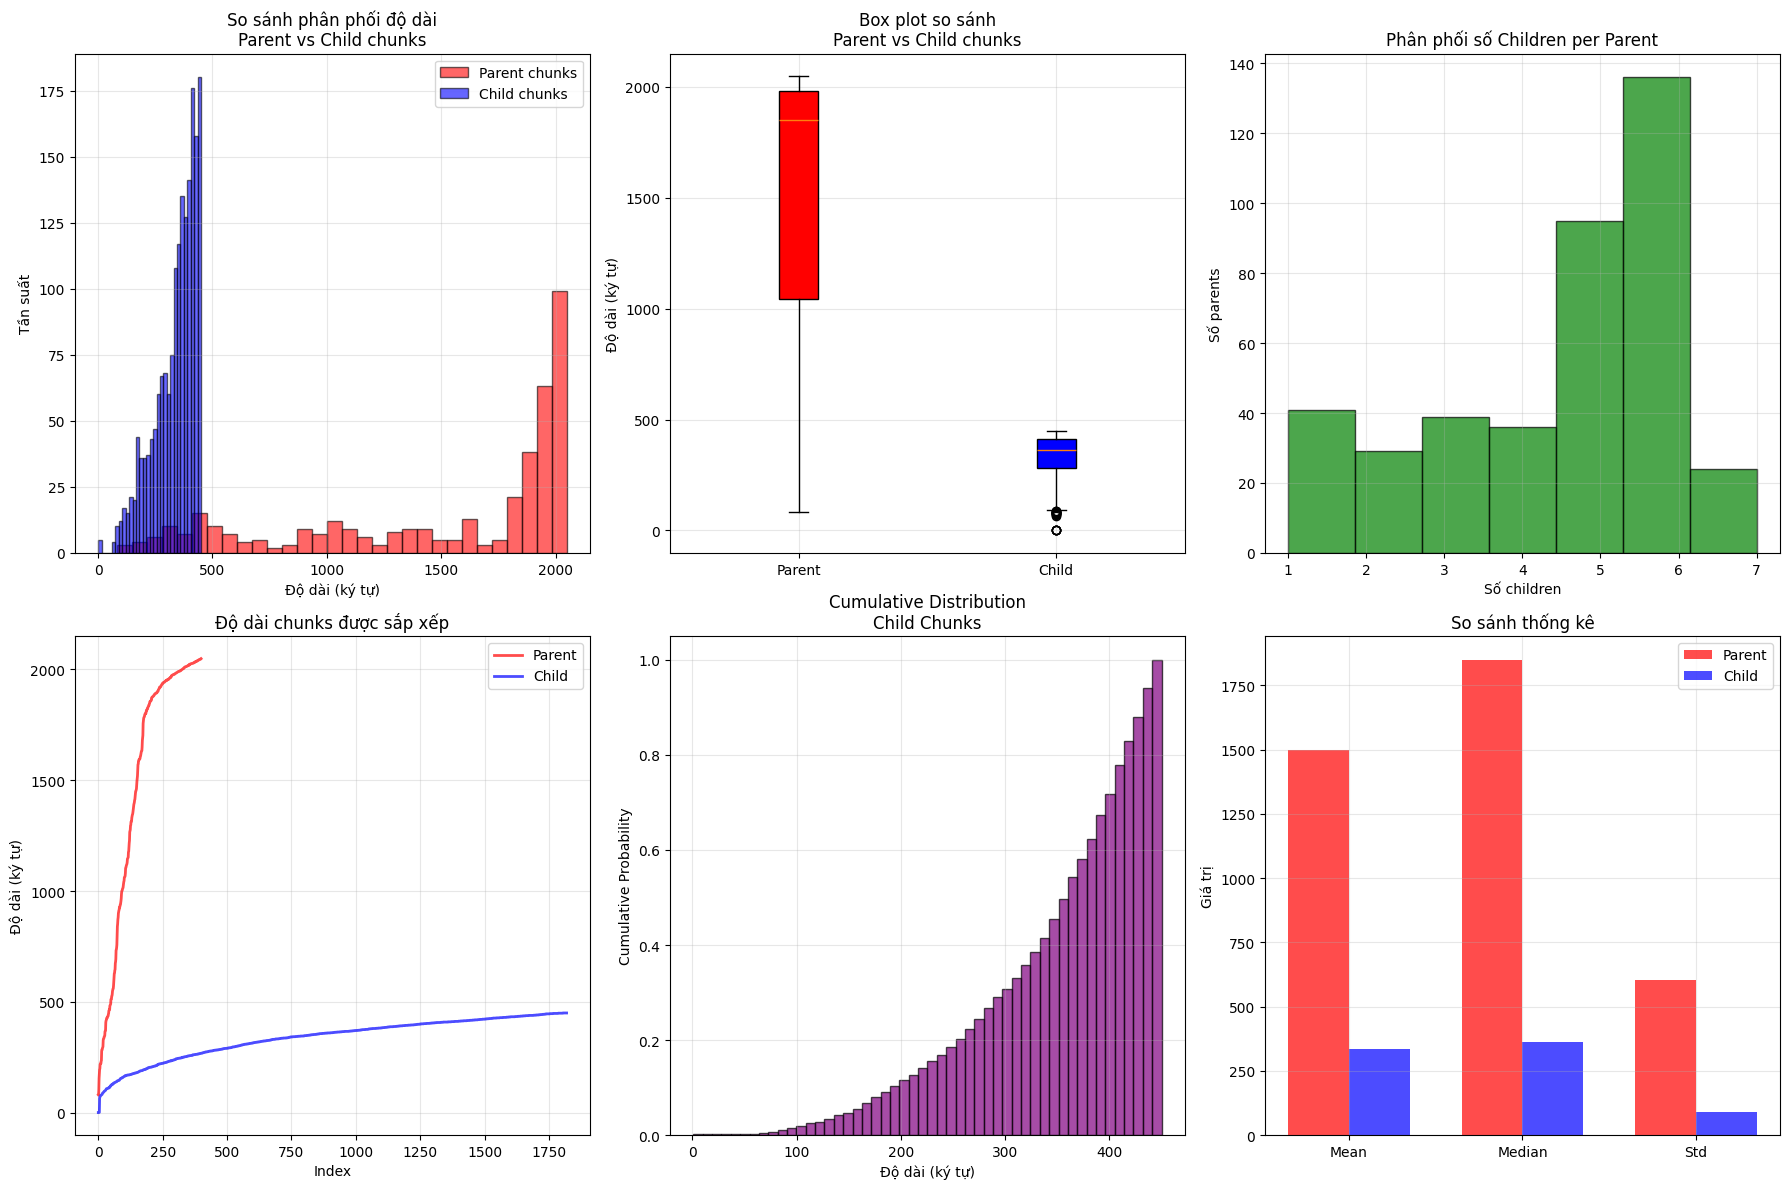


TÓM TẮT KẾT QUẢ PARENT DOCUMENT CHUNKING
HIỆU QUẢ CHUNKING:
  Tăng từ 400 → 1819 chunks (4.5x)
  Giảm độ dài trung bình: 1499 → 337 ký tự
  Tỷ lệ chunks < 500 ký tự: 100.0%
  Độ lệch chuẩn giảm: 604 → 91

OUTPUT FILES:
  Original dense chunks: ./Lich_Su_Dang_Dense_Global.json
  Child chunks (optimal): ./TrietHoc_Child_Dense_Optimal.json

SẴN SÀNG CHO PARENT DOCUMENT RETRIEVAL!
  Child chunks để tìm kiếm (high recall)
  Parent chunks để context (full information)
  Metadata đầy đủ cho filtering và ranking


In [23]:
# Lưu file child chunks tối ưu và visualization
optimal_output_file = "./TrietHoc_Child_Dense_Optimal.json"

try:
    save_chunks_to_json(child_chunks_optimal, optimal_output_file)
    print(f"ĐÃ LƯU THÀNH CÔNG!")
    print(f"File: {optimal_output_file}")
    print(f"Số child chunks: {len(child_chunks_optimal)}")
    
    # Kiểm tra file
    import os
    if os.path.exists(optimal_output_file):
        file_size = os.path.getsize(optimal_output_file) / (1024 * 1024)  # MB
        print(f"Kích thước file: {file_size:.2f} MB")
    
except Exception as e:
    print(f"Lỗi khi lưu file: {e}")

# Comprehensive Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. So sánh phân phối độ dài trước/sau chunking
axes[0, 0].hist(content_lengths, bins=30, alpha=0.6, label='Parent chunks', color='red', edgecolor='black')
axes[0, 0].hist(child_lengths_optimal, bins=30, alpha=0.6, label='Child chunks', color='blue', edgecolor='black')
axes[0, 0].set_title('So sánh phân phối độ dài\nParent vs Child chunks')
axes[0, 0].set_xlabel('Độ dài (ký tự)')
axes[0, 0].set_ylabel('Tần suất')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot so sánh
data_to_plot = [content_lengths, child_lengths_optimal]
bp = axes[0, 1].boxplot(data_to_plot, labels=['Parent', 'Child'], patch_artist=True)
bp['boxes'][0].set_facecolor('red')
bp['boxes'][1].set_facecolor('blue')
axes[0, 1].set_title('Box plot so sánh\nParent vs Child chunks')
axes[0, 1].set_ylabel('Độ dài (ký tự)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Phân phối số children per parent
children_per_parent_optimal = {}
for chunk in child_chunks_optimal:
    parent_id = chunk['metadata']['parent_id']
    children_per_parent_optimal[parent_id] = children_per_parent_optimal.get(parent_id, 0) + 1

children_counts_optimal = list(children_per_parent_optimal.values())
axes[0, 2].hist(children_counts_optimal, bins=max(children_counts_optimal), alpha=0.7, color='green', edgecolor='black')
axes[0, 2].set_title('Phân phối số Children per Parent')
axes[0, 2].set_xlabel('Số children')
axes[0, 2].set_ylabel('Số parents')
axes[0, 2].grid(True, alpha=0.3)

# 4. Sorted lengths
axes[1, 0].plot(range(len(content_lengths)), sorted(content_lengths), 'r-', alpha=0.7, label='Parent', linewidth=2)
axes[1, 0].plot(range(len(child_lengths_optimal)), sorted(child_lengths_optimal), 'b-', alpha=0.7, label='Child', linewidth=2)
axes[1, 0].set_title('Độ dài chunks được sắp xếp')
axes[1, 0].set_xlabel('Index')
axes[1, 0].set_ylabel('Độ dài (ký tự)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Cumulative distribution
axes[1, 1].hist(child_lengths_optimal, bins=50, cumulative=True, density=True, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_title('Cumulative Distribution\nChild Chunks')
axes[1, 1].set_xlabel('Độ dài (ký tự)')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].grid(True, alpha=0.3)

# 6. Statistics comparison
stats_parent = [np.mean(content_lengths), np.median(content_lengths), np.std(content_lengths)]
stats_child = [np.mean(child_lengths_optimal), np.median(child_lengths_optimal), np.std(child_lengths_optimal)]
x_pos = np.arange(3)
width = 0.35

axes[1, 2].bar(x_pos - width/2, stats_parent, width, label='Parent', color='red', alpha=0.7)
axes[1, 2].bar(x_pos + width/2, stats_child, width, label='Child', color='blue', alpha=0.7)
axes[1, 2].set_title('So sánh thống kê')
axes[1, 2].set_ylabel('Giá trị')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(['Mean', 'Median', 'Std'])
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final summary
print(f"\nTÓM TẮT KẾT QUẢ PARENT DOCUMENT CHUNKING")
print("="*60)
print(f"HIỆU QUẢ CHUNKING:")
print(f"  Tăng từ {len(dense_chunk)} → {len(child_chunks_optimal)} chunks ({len(child_chunks_optimal)/len(dense_chunk):.1f}x)")
print(f"  Giảm độ dài trung bình: {np.mean(content_lengths):.0f} → {np.mean(child_lengths_optimal):.0f} ký tự")
print(f"  Tỷ lệ chunks < 500 ký tự: {len([l for l in child_lengths_optimal if l <= 500])/len(child_chunks_optimal)*100:.1f}%")
print(f"  Độ lệch chuẩn giảm: {np.std(content_lengths):.0f} → {np.std(child_lengths_optimal):.0f}")

print(f"\nOUTPUT FILES:")
print(f"  Original dense chunks: ./Lich_Su_Dang_Dense_Global.json")
print(f"  Child chunks (optimal): {optimal_output_file}")

print(f"\nSẴN SÀNG CHO PARENT DOCUMENT RETRIEVAL!")
print(f"  Child chunks để tìm kiếm (high recall)")
print(f"  Parent chunks để context (full information)")
print(f"  Metadata đầy đủ cho filtering và ranking")